In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
from sklearn.datasets import load_iris
data = load_iris()

In [4]:
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

In [5]:
pdData = pd.DataFrame(features, columns=feature_names)

In [6]:
pdData['target'] = target

In [7]:
from sklearn.utils import shuffle  
pdData = shuffle(pdData)

In [8]:
train = pdData.head(105)
test = pdData.tail(45)

In [9]:
train.shape, test.shape

((105, 5), (45, 5))

In [10]:
train = train.where(train.target != 2).dropna()

In [11]:
train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
10,5.4,3.7,1.5,0.2,0.0
61,5.9,3.0,4.2,1.5,1.0
83,6.0,2.7,5.1,1.6,1.0
76,6.8,2.8,4.8,1.4,1.0
67,5.8,2.7,4.1,1.0,1.0


In [12]:
train['target'].value_counts()

1.0    36
0.0    33
Name: target, dtype: int64

In [13]:
test = test.where(test.target !=2).dropna()

In [14]:
test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
88,5.6,3.0,4.1,1.3,1.0
69,5.6,2.5,3.9,1.1,1.0
13,4.3,3.0,1.1,0.1,0.0
18,5.7,3.8,1.7,0.3,0.0
38,4.4,3.0,1.3,0.2,0.0


For Modeling and Cross-validation

In [15]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds,
                         metrics='auc',early_stopping_rounds=early_stopping_rounds)
        print (cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
        
    # Fit the algorithmn on the data
    alg.fit(dtrain[predictors], dtrain['target'], eval_metric='auc')
    
    # Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # Print model report
    print ('\n Model Report')
    print ('Accuracy : %.4g' % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print ('AUC Score (Train): %f'% metrics.roc_auc_score(dtrain['target'], dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Step1 - Find the number of estimators for a high learning rate

1

 Model Report
Accuracy : 1
AUC Score (Train): 1.000000


C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


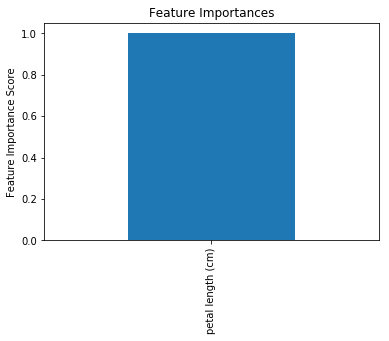

In [16]:
predictors = [x for x in train.columns if x not in ['target']]
xgb1 = XGBClassifier(
        learning_rate = 0.1,
        n_estimator = 1000,
        max_depth = 5,
        min_child_weight = 1,
        gamma = 0,
        subsample = 0.8,
        objective = 'binary:logistic',
        nthread = 4,
        scale_pos_weight = 1,
        seed = 27)

modelfit(xgb1, train, test, predictors)

In [17]:
# Grid search on subsample and max_features
# Choose all predictors except target
param_test1 = {
    'max_depth':[3, 5, 7, 9],
    'min_child_weight':[1, 3, 5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=128, max_depth=5,
                                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                       param_grid = param_test1, scoring = 'roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(train[predictors], train['target'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=128,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [18]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 1.00000, std: 0.00000, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [19]:
# Grid search on subsample and max_features
# Choose all predictors except target
param_test2 = {
    'gamma':[i/10 for i in range(0, 5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=128, max_depth=3,
                                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                       param_grid = param_test2, scoring = 'roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(train[predictors], train['target'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=128,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [20]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 1.00000, std: 0.00000, params: {'gamma': 0.0},
  mean: 1.00000, std: 0.00000, params: {'gamma': 0.1},
  mean: 1.00000, std: 0.00000, params: {'gamma': 0.2},
  mean: 1.00000, std: 0.00000, params: {'gamma': 0.3},
  mean: 1.00000, std: 0.00000, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 1.0)

1

 Model Report
Accuracy : 1
AUC Score (Train): 1.000000


C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


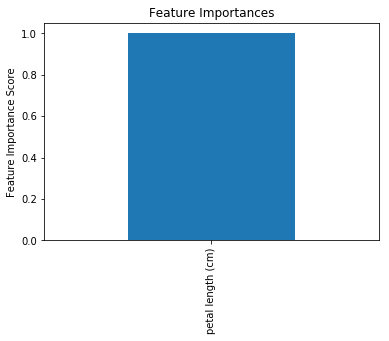

In [21]:
predictors = [x for x in train.columns if x not in ['target']]
xgb2 = XGBClassifier(
        learning_rate = 0.1,
        n_estimator = 1000,
        max_depth = 3,
        min_child_weight = 1,
        gamma = 0,
        subsample = 0.8,
        objective = 'binary:logistic',
        nthread = 4,
        scale_pos_weight = 1,
        seed = 27)

modelfit(xgb2, train, test, predictors)

In [22]:
# Grid search on subsample and max_features
# Choose all predictors except target
param_test3 = {
    'subsample':[i/10 for i in range(6, 10)],
    'colsample_bytree':[0.6, 0.7, 0.8, 0.9]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=1, max_depth=3,
                                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                       param_grid = param_test3, scoring = 'roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(train[predictors], train['target'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [23]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 1.00000, std: 0.00000, params: {'colsample_bytree': 0.8, 'subsample'

In [25]:
# Grid search on subsample and max_features
# Choose all predictors except target
param_test4 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=1, max_depth=3,
                                                 min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.6,
                                                 objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
                       param_grid = param_test4, scoring = 'roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(train[predictors], train['target'])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [26]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 1.00000, std: 0.00000, params: {'reg_alpha': 0},
  mean: 1.00000, std: 0.00000, params: {'reg_alpha': 0.001},
  mean: 1.00000, std: 0.00000, params: {'reg_alpha': 0.005},
  mean: 1.00000, std: 0.00000, params: {'reg_alpha': 0.01},
  mean: 1.00000, std: 0.00000, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 1.0)

1

 Model Report
Accuracy : 1
AUC Score (Train): 1.000000


C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


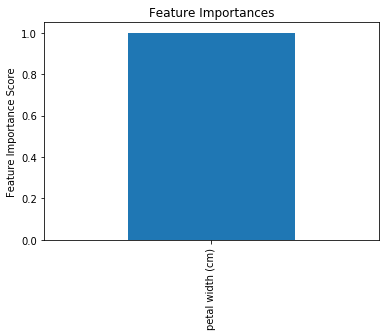

In [27]:
predictors = [x for x in train.columns if x not in ['target']]
xgb3 = XGBClassifier(
        learning_rate = 0.1,
        n_estimator = 1000,
        max_depth = 3,
        min_child_weight = 1,
        gamma = 0,
        subsample = 0.6,
        colsample_bytree = 0.6,
        reg_alpha = 0,
        objective = 'binary:logistic',
        nthread = 4,
        scale_pos_weight = 1,
        seed = 27)

modelfit(xgb3, train, test, predictors)

Change learning_rate and n_estimator

1

 Model Report
Accuracy : 1
AUC Score (Train): 1.000000


C:\Users\chenx\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


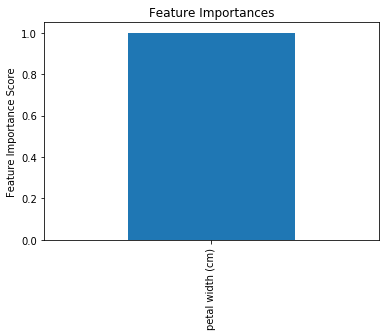

In [28]:
predictors = [x for x in train.columns if x not in ['target']]
xgb3 = XGBClassifier(
        learning_rate = 0.01,
        n_estimator = 5000,
        max_depth = 3,
        min_child_weight = 1,
        gamma = 0,
        subsample = 0.6,
        colsample_bytree = 0.6,
        reg_alpha = 0,
        objective = 'binary:logistic',
        nthread = 4,
        scale_pos_weight = 1,
        seed = 27)

modelfit(xgb3, train, test, predictors)